In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import textattack
from textattack.models.wrappers import ModelWrapper
from textattack.datasets import HuggingFaceDataset
from textattack.attack_recipes import TextFoolerJin2019, DeepWordBugGao2018, Pruthi2019, TextBuggerLi2018

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# https://www.gitmemory.com/issue/QData/TextAttack/424/795806095

C:\Users\sleev\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
class CustomModelWrapper(ModelWrapper):
    def __init__(self, model, tokenizer, batch_size=4):
        self.model = model
        self.tokenizer = tokenizer
        self.device = next(self.model.parameters()).device
        self.batch_size = batch_size

    def __call__(self, text_input_list):
        out = []
        i = 0
        while i < len(text_input_list):
            batch = text_input_list[i : i + self.batch_size]
            encoding = self.tokenizer(batch, padding=True, truncation=True, max_length=250, return_tensors='pt')
            outputs = self.model(encoding['input_ids'].to(self.device), attention_mask=encoding['attention_mask'].to(self.device))
            preds = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu()
            out.append(preds)
            i += self.batch_size
        out = torch.cat(out)
        return out

In [4]:
# dataset = HuggingFaceDataset("glue", "sst2", "train", shuffle=True)

# num_examples = 100

# MODEL_NAMES = ['bert-base-uncased', 'roberta-base', 'xlnet-base-cased']
# ts = ['ORIG', 'INV', 'SIB', 'INVSIB', 'TextMix', 'SentMix', 'WordMix']
# recipes = [TextFoolerJin2019, DeepWordBugGao2018, Pruthi2019, TextBuggerLi2018]

# results = []

# for MODEL_NAME in MODEL_NAMES:
#     for t in ts: 
        
#         checkpoint = 'pretrained/' + MODEL_NAME + "-sst2-ORIG+" + t 
#         recent_checkpoint = [name for name in os.listdir(checkpoint) if 'checkpoint' in name]
#         if recent_checkpoint:
#             checkpoint = os.path.join(checkpoint, recent_checkpoint[0])
#         model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2).to(device)
#         tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        
#         print(checkpoint, "initialized...")

#         mw = CustomModelWrapper(model, tokenizer)
        
#         for recipe in recipes:

#             attack = recipe.build(mw)
#             attack_results = attack.attack_dataset(dataset, indices=range(num_examples))

#             num_results = 0
#             num_failures = 0
#             num_successes = 0

#             for result in attack_results:
                
#                 # print(result.__str__(color_method='ansi'))
                
#                 num_results += 1
#                 if (type(result) == textattack.attack_results.SuccessfulAttackResult or 
#                     type(result) == textattack.attack_results.MaximizedAttackResult):
#                     num_successes += 1
#                 if type(result) == textattack.attack_results.FailedAttackResult:
#                     num_failures += 1

#             attack_success = num_successes / num_results
#             results.append({
#                 'checkpoint': checkpoint,
#                 'recipe': recipe.__name__,
#                 'attack_success': attack_success
#             })

#             print("{0} Attack Success: {1:0.2f}".format(recipe.__name__, attack_success))

In [5]:
# df = pd.DataFrame(results)
# df.to_csv('adv_attack_sst2.csv')

In [6]:
# df

In [18]:
df = pd.read_csv('adv_attack_sst2.csv')

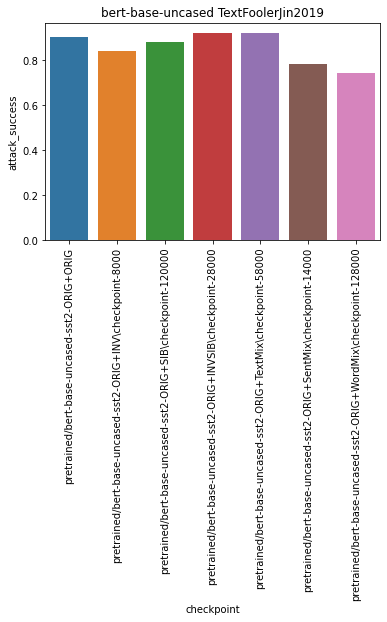

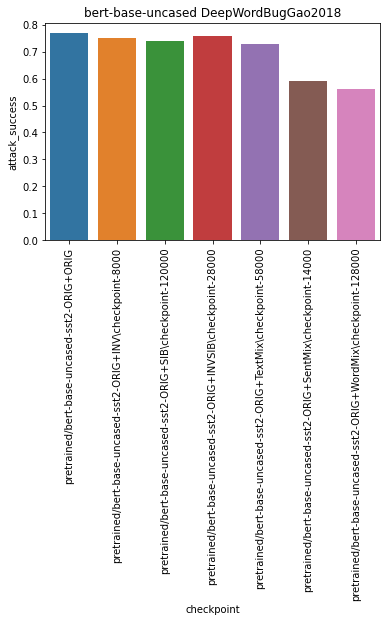

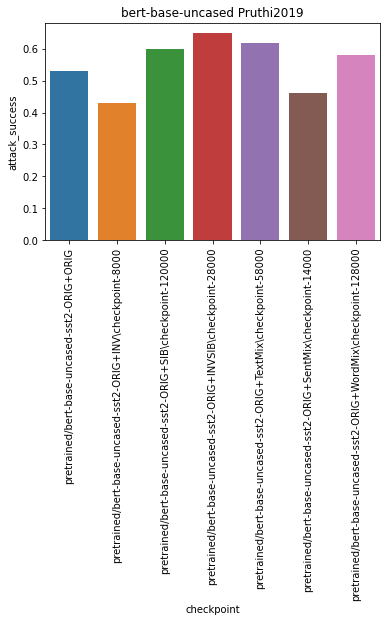

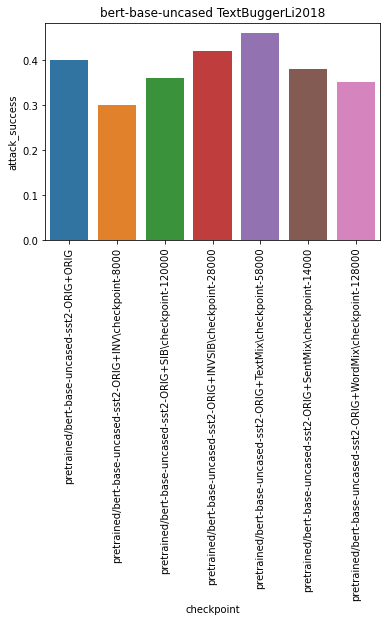

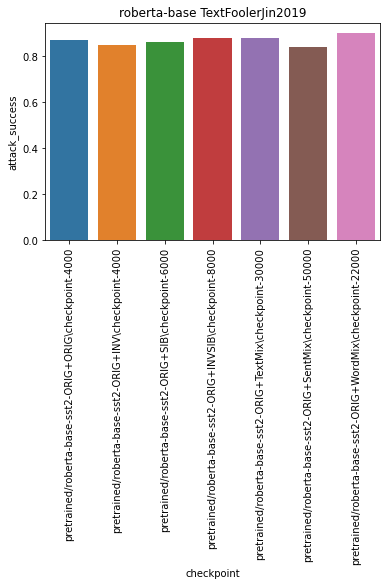

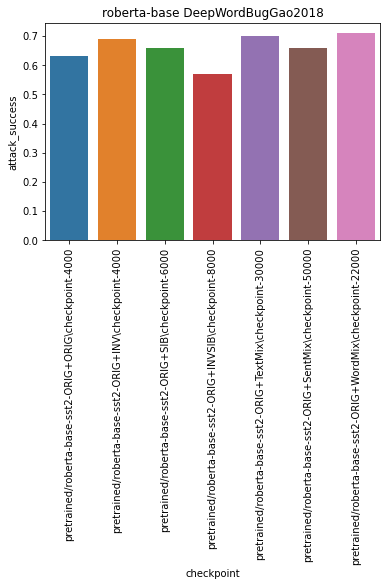

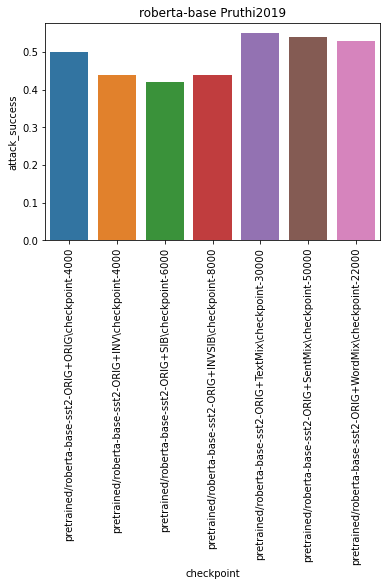

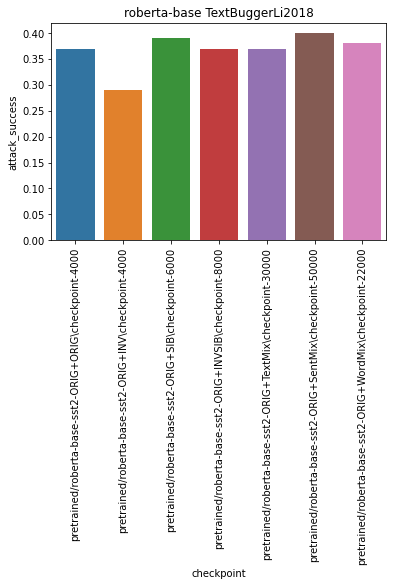

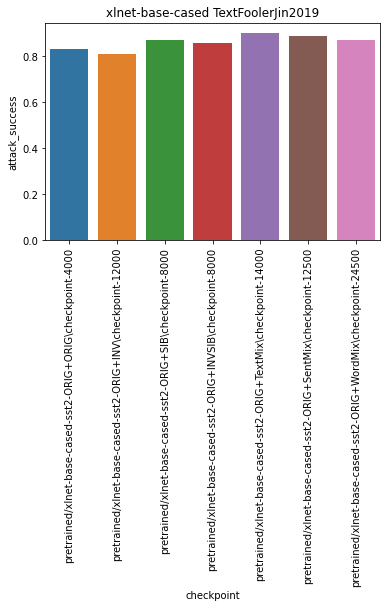

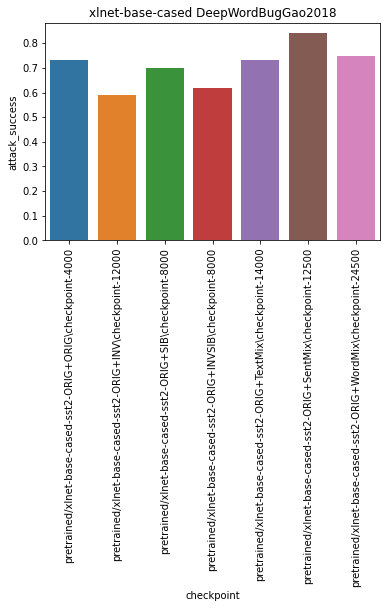

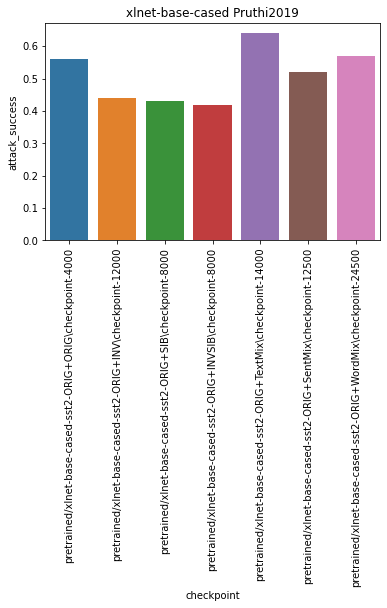

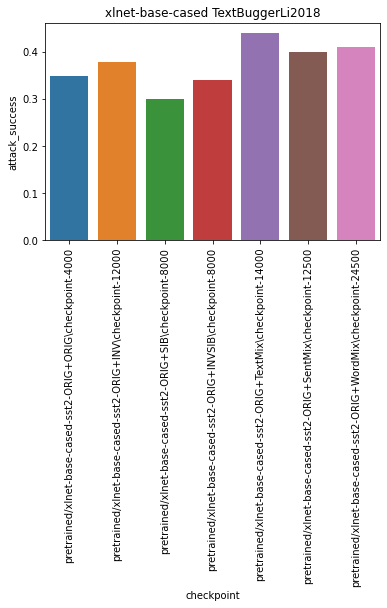

In [19]:
for MODEL_NAME in MODEL_NAMES:
    for r in recipes:
        r = r.__name__
        idx = df['checkpoint'].str.contains(MODEL_NAME) 
        idx2 = df['recipe'].str.contains(r)
        g = sns.barplot(data=df[idx & idx2], x="checkpoint", y="attack_success")
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
        g.set_title(MODEL_NAME + ' ' + r)
        plt.show()

In [8]:
dataset = HuggingFaceDataset("ag_news", None, "test", shuffle=True)

num_examples = 100

MODEL_NAMES = ['bert-base-uncased', 'roberta-base', 'xlnet-base-cased']
ts = ['ORIG', 'INV', 'SIB', 'INVSIB', 'TextMix', 'SentMix', 'WordMix']
recipes = [TextFoolerJin2019, DeepWordBugGao2018, Pruthi2019, TextBuggerLi2018]

results = []

for MODEL_NAME in MODEL_NAMES:
    for t in ts: 
        
        checkpoint = 'pretrained/' + MODEL_NAME + "-ag_news-ORIG+" + t 
        recent_checkpoint = [name for name in os.listdir(checkpoint) if 'checkpoint' in name]
        if recent_checkpoint:
            checkpoint = os.path.join(checkpoint, recent_checkpoint[0])
        model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4).to(device)
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        
        print(checkpoint, "initialized...")

        mw = CustomModelWrapper(model, tokenizer)
        
        for recipe in recipes:

            attack = recipe.build(mw)
            attack_results = attack.attack_dataset(dataset, indices=range(num_examples))

            num_results = 0
            num_failures = 0
            num_successes = 0

            for result in attack_results:
                
                # print(result.__str__(color_method='ansi'))
                
                num_results += 1
                if (type(result) == textattack.attack_results.SuccessfulAttackResult or 
                    type(result) == textattack.attack_results.MaximizedAttackResult):
                    num_successes += 1
                if type(result) == textattack.attack_results.FailedAttackResult:
                    num_failures += 1

            attack_success = num_successes / num_results
            results.append({
                'checkpoint': checkpoint,
                'recipe': recipe.__name__,
                'attack_success': attack_success
            })

            print("{0} Attack Success: {1:0.2f}".format(recipe.__name__, attack_success))

Using custom data configuration default
Reusing dataset ag_news (C:\Users\sleev\.cache\huggingface\datasets\ag_news\default\0.0.0\0eeeaaa5fb6dffd81458e293dfea1adba2881ffcbdc3fb56baeb5a892566c29a)
textattack: Loading datasets dataset ag_news, split test.
Using C:\Users\sleev\AppData\Local\Temp\tfhub_modules to cache modules.


pretrained/bert-base-uncased-ag_news-ORIG+ORIG\checkpoint-10000 initialized...


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.81


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.78
Pruthi2019 Attack Success: 0.15


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.52
pretrained/bert-base-uncased-ag_news-ORIG+INV\checkpoint-20000 initialized...


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.68


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.54
Pruthi2019 Attack Success: 0.15


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.43
pretrained/bert-base-uncased-ag_news-ORIG+SIB\checkpoint-5000 initialized...


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.76


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.65
Pruthi2019 Attack Success: 0.06


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.40
pretrained/bert-base-uncased-ag_news-ORIG+INVSIB\checkpoint-25000 initialized...


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.84


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.79
Pruthi2019 Attack Success: 0.18


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.59
pretrained/bert-base-uncased-ag_news-ORIG+TextMix\checkpoint-5000 initialized...


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.72


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.62
Pruthi2019 Attack Success: 0.07


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.37
pretrained/bert-base-uncased-ag_news-ORIG+SentMix\checkpoint-15000 initialized...


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.80


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.73
Pruthi2019 Attack Success: 0.08


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.57
pretrained/bert-base-uncased-ag_news-ORIG+WordMix\checkpoint-25000 initialized...


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.78


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.65
Pruthi2019 Attack Success: 0.05


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.47
pretrained/roberta-base-ag_news-ORIG+ORIG\checkpoint-5000 initialized...


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.69


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.52
Pruthi2019 Attack Success: 0.10


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.39
pretrained/roberta-base-ag_news-ORIG+INV\checkpoint-15000 initialized...


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.77


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.69
Pruthi2019 Attack Success: 0.10


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.41
pretrained/roberta-base-ag_news-ORIG+SIB\checkpoint-10000 initialized...


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.67


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.57
Pruthi2019 Attack Success: 0.11


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.47
pretrained/roberta-base-ag_news-ORIG+INVSIB\checkpoint-10000 initialized...


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.66


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.54
Pruthi2019 Attack Success: 0.06


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.39
pretrained/roberta-base-ag_news-ORIG+TextMix\checkpoint-20000 initialized...


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.77


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.56
Pruthi2019 Attack Success: 0.12


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.53
pretrained/roberta-base-ag_news-ORIG+SentMix\checkpoint-15000 initialized...


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.70


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.59
Pruthi2019 Attack Success: 0.13


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.46
pretrained/roberta-base-ag_news-ORIG+WordMix\checkpoint-20000 initialized...


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.80


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.64
Pruthi2019 Attack Success: 0.07


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.39
pretrained/xlnet-base-cased-ag_news-ORIG+ORIG\checkpoint-5000 initialized...


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.69


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.59
Pruthi2019 Attack Success: 0.11


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.44
pretrained/xlnet-base-cased-ag_news-ORIG+INV\checkpoint-10000 initialized...


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.74


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.57
Pruthi2019 Attack Success: 0.07


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.36
pretrained/xlnet-base-cased-ag_news-ORIG+SIB\checkpoint-10000 initialized...


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.72


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.55
Pruthi2019 Attack Success: 0.08


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.42
pretrained/xlnet-base-cased-ag_news-ORIG+INVSIB\checkpoint-5000 initialized...


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.84


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.66
Pruthi2019 Attack Success: 0.11


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.44
pretrained/xlnet-base-cased-ag_news-ORIG+TextMix\checkpoint-20000 initialized...


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.74


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.68
Pruthi2019 Attack Success: 0.09


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.43
pretrained/xlnet-base-cased-ag_news-ORIG+SentMix\checkpoint-10000 initialized...


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.77


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.60
Pruthi2019 Attack Success: 0.05


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.38
pretrained/xlnet-base-cased-ag_news-ORIG+WordMix\checkpoint-25000 initialized...


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.88


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.69
Pruthi2019 Attack Success: 0.06


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextBuggerLi2018 Attack Success: 0.44


In [9]:
df = pd.DataFrame(results)
df.to_csv('adv_attack_ag_news.csv')

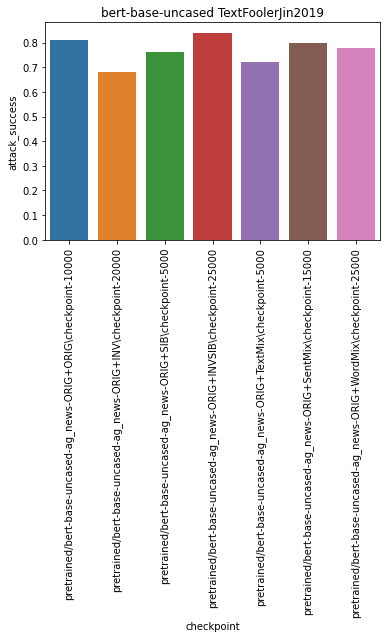

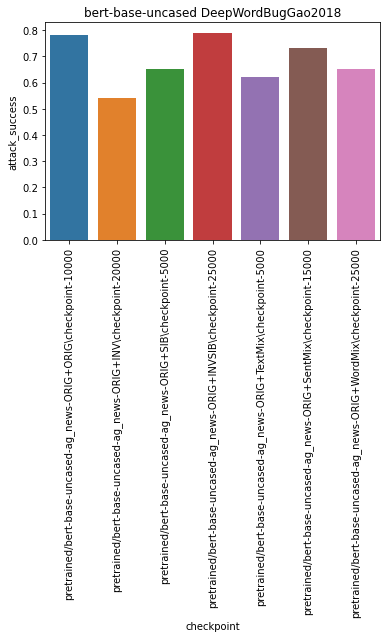

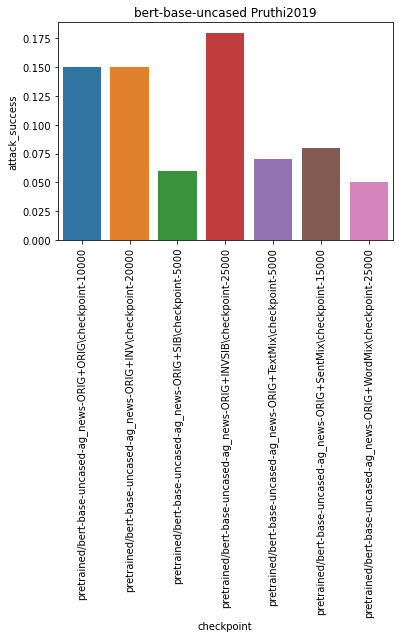

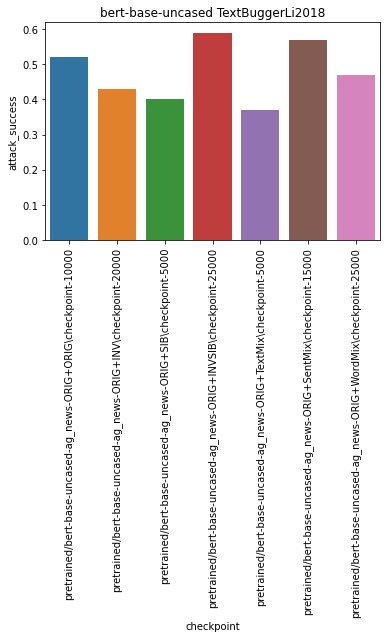

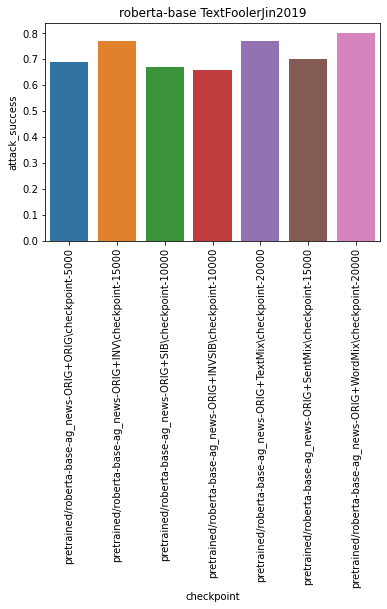

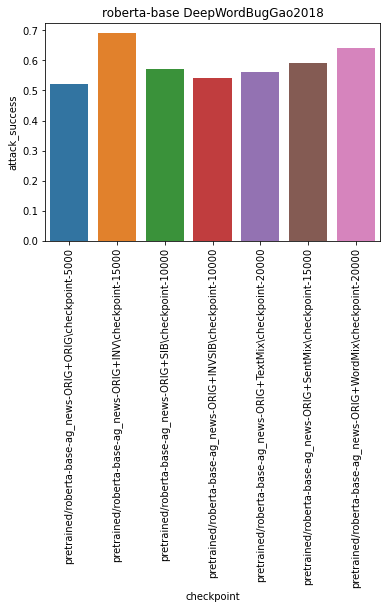

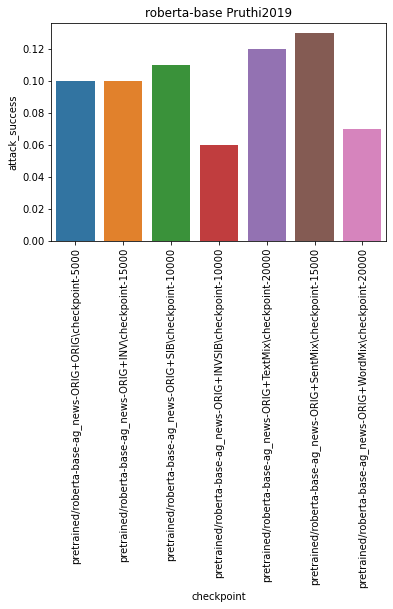

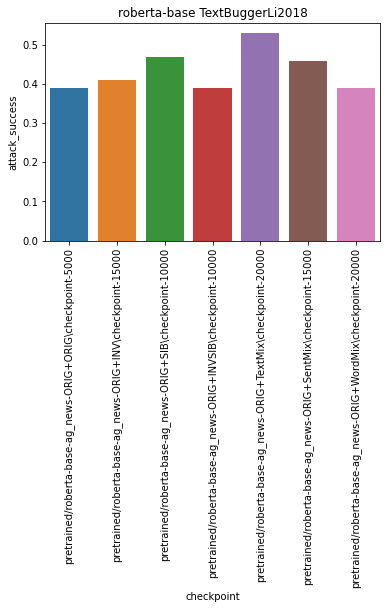

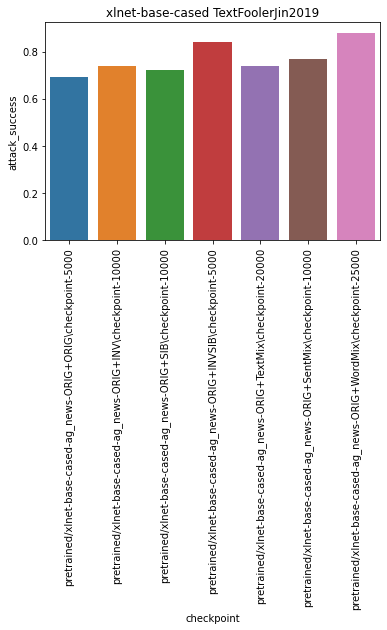

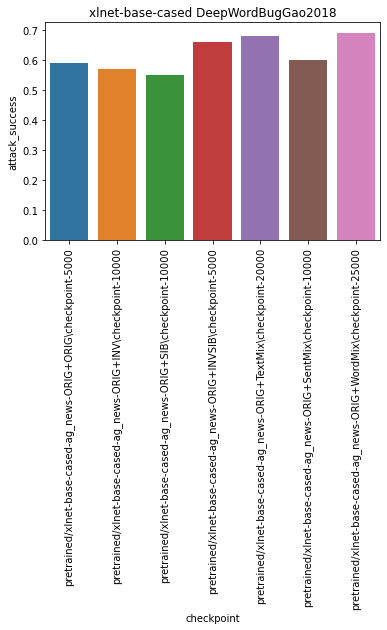

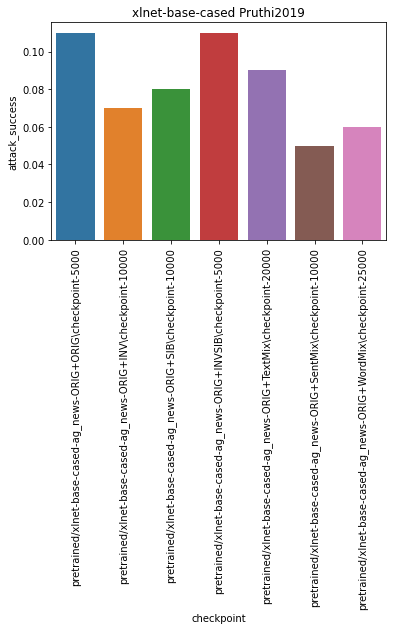

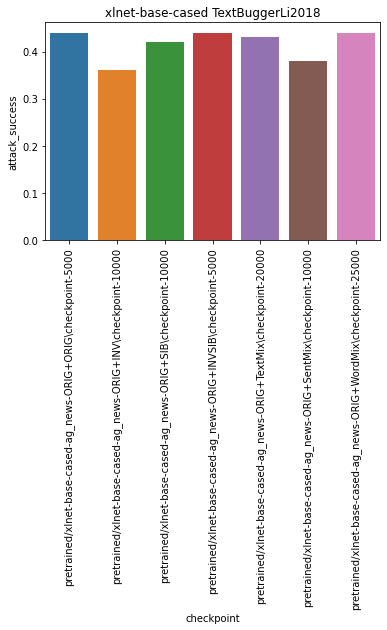

In [17]:
for MODEL_NAME in MODEL_NAMES:
    for r in recipes:
        r = r.__name__
        idx = df['checkpoint'].str.contains(MODEL_NAME) 
        idx2 = df['recipe'].str.contains(r)
        g = sns.barplot(data=df[idx & idx2], x="checkpoint", y="attack_success")
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
        g.set_title(MODEL_NAME + ' ' + r)
        plt.show()